In [204]:
#Importing necessary dependencies
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [205]:
#Loading dataset
data = pd.read_csv('/UNSW_NB15_training-set.csv')
test = pd.read_csv('/UNSW_NB15_testing-set.csv')

In [206]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.00000,8.233200e+04,8.233200e+04,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,4.753692,6.308556,755.394301,121.701284,6.363075e+03,535.180430,133.45908,1.084642e+09,1.073465e+09,128.28662,0.055925,0.029256,0.026669,139.528604,116.275069,0.094277,1.595372e+03,9.546604,1.369273,5.744923,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,64.649620,55.708021,6182.615732,1292.378499,5.672402e+04,3635.305383,127.35700,1.390860e+09,1.381996e+09,127.49137,0.116022,0.070854,0.055094,208.472063,244.600271,0.542922,3.806697e+04,11.090289,1.067188,8.418112,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,1.000000,0.000000,0.557928,0.010000,1.762392e+01,0.000000,255.00000,2.788886e+07,2.856975e+07,255.00000,0.000551,0.000441,0.000080,65.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,3.000000,2.000000,63.409444,63.136369,3.219332e+03,128.459914,255.00000,2.171310e+09,2.144205e+09,255.00000,0.105541,0.052595,0.048816,100.000000,87.000000,0.000000,0.000000e+00,11.000000,2.000000,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,60009.992000,57739.240000,1.483831e+06,463199.240100,255.00000,4.294950e+09,4.294881e+09,255.00000,3.821465,3.226788,2.928778,1504.000000,1500.000000,131.000000,5.242880e+06,63.000000,6.000000,59.000000,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [207]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.7,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.0,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0


In [208]:
#Dropping attack category column since problem is binary classification
data.drop(columns = 'attack_cat', inplace = True)

In [209]:
test.drop(columns = 'attack_cat', inplace = True)

In [210]:
#Dropping NaN values
data.dropna(inplace = True)

In [211]:
print(data.iloc[: , :-1].values)

[[1 1.1e-05 'udp' ... 1 2 0]
 [2 8e-06 'udp' ... 1 2 0]
 [3 5e-06 'udp' ... 1 3 0]
 ...
 [82330 0.0 'arp' ... 1 1 1]
 [82331 0.0 'arp' ... 1 1 1]
 [82332 9e-06 'udp' ... 1 1 0]]


In [212]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.7,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.0,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,0


In [213]:
#Idenitfying and displaying categorical values
for column in data.columns:
  if data[column].dtypes == 'object':
    uniquecat = len(data[column].unique())
    print("Feature '{column}' has {uniquecat} categories".format(column=column, uniquecat=uniquecat))

Feature 'proto' has 131 categories
Feature 'service' has 13 categories
Feature 'state' has 7 categories


In [214]:
#Checking for null values in the dataset
data.isnull().sum().sum()

0

In [215]:
#Information about the dataset
data.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')

In [216]:
#Finding percentage of normal and attack classes where attack is represented by 1 and normal is represented by 0
nortr, attacktr = data['label'].value_counts()[0] / len(data.index), data['label'].value_counts()[1] / len(data.index)
norte, attackte = test['label'].value_counts()[0] / len(test.index), test['label'].value_counts()[1] / len(test.index)

In [217]:
#Displaying the percentage
print("Training dataset: contains {} % of normal classes and {} % of attack classes".format(nortr*100, attacktr*100))
print("Testing dataset: contains {} % of normal classes and {} % of attack classes".format(norte*100, attackte*100))

Training dataset: contains 44.939999028324344 % of normal classes and 55.06000097167566 % of attack classes
Testing dataset: contains 31.93776697977085 % of normal classes and 68.06223302022916 % of attack classes


In [218]:
#Finding the counts of all datatypes in the dataset
data.dtypes.value_counts()

int64      30
float64    11
object      3
dtype: int64

In [219]:
#As already discovered, there are only 3 categorical features and they are - Service, Proto, and State
#Displaying value counts
data['service'].value_counts()

-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64

In [220]:
#Displaying value counts again
data['service'].value_counts()

-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64

In [221]:
#Allocating input or predictors to x
X_train, Y_train = data.drop(columns=['label']), data['label']
X_test, Y_test = test.drop(columns=['label']), test['label']
X_test.reset_index(drop=True, inplace=True)

In [222]:
test

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,1


In [223]:
#Storing copies of numerical values
totalvalues = ['proto', 'service', 'state', 'label']
numericalvalues = list(set(data.columns) - set(totalvalues))

In [224]:
#Preprocessing of data - 
#Normalization using Min-Max scaler
scaler = MinMaxScaler()
scaler.fit(X_train[numericalvalues])
X_train[numericalvalues] = scaler.transform(X_train[numericalvalues])
X_test[numericalvalues] = scaler.transform(X_test[numericalvalues])

In [225]:
#corr_matrix = X_train.corr().abs()
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [226]:
def corr_df(x, corr_val):
  #Creates Correlation Matrix
  corr_matrix = x.corr()
  iters = range(len(corr_matrix.columns) - 1)
  drop_cols = []

  #Iterates through Correlation Matrix Table to find correlated columns
  for i in iters:
    for j in range(i):
      item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
      col = item.columns
      row = item.index
      val = item.values
      if abs(val) >= corr_val:
        #Prints the correlated feature set and the corr val
        print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
        drop_cols.append(i)
  
  drops = sorted(set(drop_cols))[::-1]
  #Dropping the correlated columns
  for i in drops:
    col = x.iloc[:, (i+1):(i+2)].columns.values
    x = x.drop(col, axis=1)
  return x

In [227]:
corr_df(X_train, 0.95)

sbytes | spkts | 0.97
dbytes | dpkts | 0.98
sloss | spkts | 0.97
sloss | sbytes | 1.0
dloss | dpkts | 0.98
dloss | dbytes | 1.0
dwin | swin | 0.96
ct_srv_dst | ct_srv_src | 0.98


,id,dur,proto,service,dpkts,sbytes,dbytes,rate,sttl,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000000,1.833334e-07,udp,-,0.000000,0.000033,0.000000,0.090909,0.996078,0.000000,0.000000,0.000000,1.833028e-07,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.151351,0.000000,0.0,0.0,0.016129,0.333333,0.000000,0.000000,0.0,0.016129,0.0,0.0,0.000000,0.016393,0.0
1,0.000012,1.333334e-07,udp,-,0.000000,0.000121,0.000000,0.125000,0.996078,0.000000,0.000000,0.000000,1.333111e-07,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.579054,0.000000,0.0,0.0,0.016129,0.333333,0.000000,0.000000,0.0,0.016129,0.0,0.0,0.000000,0.016393,0.0
2,0.000024,8.333335e-08,udp,-,0.000000,0.000073,0.000000,0.200000,0.996078,0.000000,0.000000,0.000000,8.331946e-08,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.344595,0.000000,0.0,0.0,0.032258,0.333333,0.000000,0.000000,0.0,0.032258,0.0,0.0,0.000000,0.032787,0.0
3,0.000036,1.000000e-07,udp,-,0.000000,0.000061,0.000000,0.166667,0.996078,0.000000,0.000000,0.000000,9.998335e-08,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.287838,0.000000,0.0,0.0,0.032258,0.333333,0.017241,0.017241,0.0,0.032258,0.0,0.0,0.016949,0.032787,0.0
4,0.000049,1.666667e-07,udp,-,0.000000,0.000146,0.000000,0.100000,0.996078,0.000000,0.000000,0.000000,1.666389e-07,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.702027,0.000000,0.0,0.0,0.032258,0.333333,0.017241,0.017241,0.0,0.032258,0.0,0.0,0.016949,0.032787,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.999951,8.333335e-08,udp,-,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,0.000000,0.000000,8.331946e-08,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.018919,0.000000,0.0,0.0,0.000000,0.333333,0.017241,0.000000,0.0,0.016129,0.0,0.0,0.016949,0.000000,0.0
82328,0.999964,1.843502e-02,tcp,-,0.000726,0.001257,0.000024,0.000024,0.996078,0.000108,0.001316,0.000182,9.311791e-04,0.002489,0.003234,0.000412,0.24972,0.764699,1.0,0.045325,0.03105,0.024931,0.593919,0.029333,0.0,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.000000,0.0,0.0,0.033898,0.016393,0.0
82329,0.999976,0.000000e+00,arp,-,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.998455e-01,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.014865,0.000000,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0
82330,0.999988,0.000000e+00,arp,-,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.998457e-01,0.000000,0.000007,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.014865,0.000000,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0


In [228]:
corr_df(X_test, 0.95)

sbytes | spkts | 0.96
dbytes | dpkts | 0.97
sloss | spkts | 0.97
sloss | sbytes | 1.0
dloss | dpkts | 0.98
dloss | dbytes | 1.0
dwin | swin | 0.99
ct_dst_src_ltm | ct_srv_src | 0.97
ct_srv_dst | ct_srv_src | 0.98
ct_srv_dst | ct_dst_src_ltm | 0.97


,id,dur,proto,service,dpkts,sbytes,dbytes,rate,sttl,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000000,2.024634e-03,tcp,-,0.000363,0.000016,0.000012,0.000074,0.988235,0.000408,0.000000,0.000000,4.048592e-04,0.000145,0.000020,0.000026,0.144768,0.512828,1.0,0.000000,0.000000,0.000000,0.012838,0.028667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000012,1.083170e-02,tcp,-,0.003449,0.000049,0.002866,0.000078,0.243137,0.024186,0.000376,0.003087,8.317781e-04,0.000267,0.000041,0.002996,0.330128,0.716525,1.0,0.000000,0.000000,0.000000,0.018919,0.737333,0.0,0.0,0.677419,0.166667,0.000000,0.000000,0.016129,0.0,0.0,0.000000,0.081967,0.0
2,0.000024,2.705215e-02,tcp,-,0.001452,0.000024,0.000900,0.000014,0.243137,0.002926,0.000188,0.001090,3.863949e-03,0.001779,0.011578,0.024657,0.492707,0.689918,1.0,0.029281,0.019046,0.017222,0.014865,0.549333,0.0,0.0,0.096774,0.166667,0.000000,0.000000,0.032258,0.0,0.0,0.016949,0.081967,0.0
3,0.000036,2.802737e-02,tcp,ftp,0.001089,0.000042,0.000053,0.000014,0.243137,0.000161,0.000188,0.000545,2.547518e-03,0.001563,0.000175,0.010777,0.257772,0.243882,1.0,0.000000,0.000000,0.000000,0.018919,0.042667,0.0,0.0,0.000000,0.166667,0.000000,0.000000,0.032258,0.5,0.0,0.016949,0.000000,0.0
4,0.000049,7.490901e-03,tcp,-,0.000545,0.000036,0.000018,0.000033,0.996078,0.000191,0.000376,0.000182,7.957064e-04,0.001310,0.001628,0.000250,0.567210,0.460351,1.0,0.033595,0.022049,0.019542,0.019595,0.030000,0.0,0.0,0.677419,0.166667,0.017241,0.000000,0.629032,0.0,0.0,0.016949,0.622951,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,2.129647,1.500000e-07,udp,dns,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.000000,0.000000,1.499750e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.370968,0.333333,0.396552,0.324324,0.370968,0.0,0.0,0.389831,0.377049,0.0
175337,2.129660,8.429368e-03,tcp,-,0.000726,0.000042,0.000024,0.000034,0.996078,0.000236,0.000376,0.000182,9.065176e-04,0.001160,0.002508,0.000259,0.819282,0.804002,1.0,0.026021,0.011434,0.021355,0.025676,0.029333,0.0,0.0,0.000000,0.166667,0.000000,0.000000,0.016129,0.0,0.0,0.000000,0.000000,0.0
175338,2.129672,1.500000e-07,udp,dns,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.000000,0.000000,1.499750e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.177419,0.333333,0.034483,0.054054,0.193548,0.0,0.0,0.033898,0.180328,0.0
175339,2.129684,1.500000e-07,udp,dns,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.000000,0.000000,1.499750e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.467742,0.333333,0.500000,0.351351,0.467742,0.0,0.0,0.491525,0.475410,0.0


In [229]:
X_test

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000000,2.024634e-03,tcp,-,FIN,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.003953,2.687726e-06,0.000408,0.000000,0.000000,4.048592e-04,0.000145,0.000020,0.000026,1.0,0.144768,0.512828,1.0,0.000000,0.000000,0.000000,0.012838,0.028667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000012,1.083170e-02,tcp,-,FIN,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.996047,1.593605e-06,0.024186,0.000376,0.003087,8.317781e-04,0.000267,0.000041,0.002996,1.0,0.330128,0.716525,1.0,0.000000,0.000000,0.000000,0.018919,0.737333,0.0,0.0,0.677419,0.166667,0.000000,0.000000,0.000000,0.016129,0.0,0.0,0.0,0.000000,0.081967,0.0
2,0.000024,2.705215e-02,tcp,-,FIN,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.996047,2.984571e-07,0.002926,0.000188,0.001090,3.863949e-03,0.001779,0.011578,0.024657,1.0,0.492707,0.689918,1.0,0.029281,0.019046,0.017222,0.014865,0.549333,0.0,0.0,0.096774,0.166667,0.017241,0.000000,0.000000,0.032258,0.0,0.0,0.0,0.016949,0.081967,0.0
3,0.000036,2.802737e-02,tcp,ftp,FIN,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.996047,5.201554e-07,0.000161,0.000188,0.000545,2.547518e-03,0.001563,0.000175,0.010777,1.0,0.257772,0.243882,1.0,0.000000,0.000000,0.000000,0.018919,0.042667,0.0,0.0,0.000000,0.166667,0.017241,0.000000,0.000000,0.032258,0.5,0.5,0.0,0.016949,0.000000,0.0
4,0.000049,7.490901e-03,tcp,-,FIN,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.996047,1.625190e-06,0.000191,0.000376,0.000182,7.957064e-04,0.001310,0.001628,0.000250,1.0,0.567210,0.460351,1.0,0.033595,0.022049,0.019542,0.019595,0.030000,0.0,0.0,0.677419,0.166667,0.017241,0.017241,0.000000,0.629032,0.0,0.0,0.0,0.016949,0.622951,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,2.129647,1.500000e-07,udp,dns,INT,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,9.617817e-03,0.000000,0.000000,0.000000,1.499750e-07,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.370968,0.333333,0.396552,0.396552,0.324324,0.370968,0.0,0.0,0.0,0.389831,0.377049,0.0
175337,2.129660,8.429368e-03,tcp,-,FIN,0.000845,0.000726,0.000042,0.000024,0.000034,0.996078,0.996047,1.675453e-06,0.000236,0.000376,0.000182,9.065176e-04,0.001160,0.002508,0.000259,1.0,0.819282,0.804002,1.0,0.026021,0.011434,0.021355,0.025676,0.029333,0.0,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.016129,0.0,0.0,0.0,0.000000,0.000000,0.0
175338,2.129672,1.500000e-07,udp,dns,INT,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,9.617817e-03,0.000000,0.000000,0.000000,1.499750e-07,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.177419,0.333333,0.034483,0.034483,0.054054,0.193548,0.0,0.0,0.0,0.033898,0.180328,0.0
175339,2.129684,1.500000e-07,udp,dns,INT,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,9.617817e-03,0.000000,0.000000,0.000000,1.499750e-07,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.467742,0.333333,0.500000,0.500000,0.351351,0.467742,0.0,0.0,0.0,0.491525,0.475410,0.0


In [230]:
#X_train.drop(columns = to_drop, inplace = True)
#X_test.drop(columns = to_drop, inplace = True)

In [231]:
serv = OneHotEncoder()
pro = OneHotEncoder()
sta = OneHotEncoder()

def encode(data):

    X = serv.fit_transform(data['service'].values.reshape(-1, 1))
    X2 = pro.fit_transform(data['proto'].values.reshape(-1, 1))
    X3 = sta.fit_transform(data['state'].values.reshape(-1, 1))

    data = pd.concat([data,
                      pd.DataFrame(X2.toarray(), columns=['proto_'+i for i in pro.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in serv.categories_[0]]),
                      pd.DataFrame(X3.toarray(), columns=['state_'+i for i in sta.categories_[0]])],
                      axis=1)

    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)

    return data

In [232]:
X_train = encode(X_train)
X_test = encode(X_test)

In [233]:
X_train

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,...,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,0.000000,1.833334e-07,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,0.000000,0.034238,0.000000,0.000000,0.000000,1.833028e-07,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.151351,0.000000,0.0,0.0,0.016129,0.333333,0.000000,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000012,1.333334e-07,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,0.000000,0.167236,0.000000,0.000000,0.000000,1.333111e-07,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.579054,0.000000,0.0,0.0,0.016129,0.333333,0.000000,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000024,8.333335e-08,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,0.000000,0.162187,0.000000,0.000000,0.000000,8.331946e-08,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.344595,0.000000,0.0,0.0,0.032258,0.333333,0.000000,0.000000,0.0,0.032258,0.0,0.0,0.0,0.000000,0.032787,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000036,1.000000e-07,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,0.000000,0.113895,0.000000,0.000000,0.000000,9.998335e-08,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.287838,0.000000,0.0,0.0,0.032258,0.333333,0.017241,0.017241,0.0,0.032258,0.0,0.0,0.0,0.016949,0.032787,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000049,1.666667e-07,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,0.000000,0.161427,0.000000,0.000000,0.000000,1.666389e-07,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.702027,0.000000,0.0,0.0,0.032258,0.333333,0.017241,0.017241,0.0,0.032258,0.0,0.0,0.0,0.016949,0.032787,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.999951,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,0.015793,0.000000,0.000000,0.000000,8.331946e-08,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.018919,0.000000,0.0,0.0,0.000000,0.333333,0.017241,0.000000,0.0,0.016129,0.0,0.0,0.0,0.016949,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [234]:
X_test

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,...,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.000000,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.003953,2.687726e-06,0.000408,0.000000,0.000000,4.048592e-04,0.000145,0.000020,0.000026,1.0,0.144768,0.512828,1.0,0.000000,0.000000,0.000000,0.012838,0.028667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000012,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.996047,1.593605e-06,0.024186,0.000376,0.003087,8.317781e-04,0.000267,0.000041,0.002996,1.0,0.330128,0.716525,1.0,0.000000,0.000000,0.000000,0.018919,0.737333,0.0,0.0,0.677419,0.166667,0.000000,0.000000,0.000000,0.016129,0.0,0.0,0.0,0.000000,0.081967,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000024,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.996047,2.984571e-07,0.002926,0.000188,0.001090,3.863949e-03,0.001779,0.011578,0.024657,1.0,0.492707,0.689918,1.0,0.029281,0.019046,0.017222,0.014865,0.549333,0.0,0.0,0.096774,0.166667,0.017241,0.000000,0.000000,0.032258,0.0,0.0,0.0,0.016949,0.081967,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000036,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.996047,5.201554e-07,0.000161,0.000188,0.000545,2.547518e-03,0.001563,0.000175,0.010777,1.0,0.257772,0.243882,1.0,0.000000,0.000000,0.000000,0.018919,0.042667,0.0,0.0,0.000000,0.166667,0.017241,0.000000,0.000000,0.032258,0.5,0.5,0.0,0.016949,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000049,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.996047,1.625190e-06,0.000191,0.000376,0.000182,7.957064e-04,0.001310,0.001628,0.000250,1.0,0.567210,0.460351,1.0,0.033595,0.022049,0.019542,0.019595,0.030000,0.0,0.0,0.677419,0.166667,0.017241,0.017241,0.000000,0.629032,0.0,0.0,0.0,0.016949,0.622951,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,2.129647,1.500000e-07,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,9.617817e-03,0.000000,0.000000,0.000000,1.499750e-07,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.370968,0.333333,0.396552,0.396552,0.324324,0.370968,0.0,0.0,0.0,0.389831,0.377049,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0

In [235]:
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

In [236]:
class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        y_pred = tf.greater_equal(y_pred, 0.5)
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)

In [237]:
def plot_loss(model_history):
  train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
  valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(train_loss, '--', color=color, label='Train Loss')
  ax1.plot(valid_loss, color=color, label='Valid Loss')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Loss')
  plt.show()

def plot_model_recall_fpr(model_history):
  train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
  valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
  train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
  valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Recall', color=color)
  ax1.set_ylim([-0.05,1.05])
  ax1.plot(train_recall, '--', color=color, label='Train Recall')
  ax1.plot(valid_recall, color=color, label='Valid Recall')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Recall and FPR')
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('False Positive Rate', color=color)  # we already handled the x-label with ax1
  ax2.plot(train_fpr, '--', color=color, label='Train FPR')
  ax2.plot(valid_fpr, color=color, label='Valid FPR')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([-0.05,1.05])
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.legend(loc='upper right')
  plt.show()

In [238]:
mlp = Sequential()
mlp.add(Dense(units=30, input_dim=X_train.shape[1], activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()]
           )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 30)                5700      
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 5,731
Trainable params: 5,731
Non-trainable params: 0
_________________________________________________________________


In [239]:
history = mlp.fit(x=X_train,
                  y=Y_train,
                  batch_size=5000,
                  epochs=100,validation_split = 0.2,
                  verbose=0).history

In [240]:
test_results = mlp.evaluate(X_test, Y_test, verbose=1)
print(f'Test results -  Accuracy: {test_results[1]*100}')

5480/5480 [==============================] - 8s 1ms/step - loss: 0.1738 - accuracy: 0.9264 - false_positive_rate: 0.1858 - recall_5: 0.9790
Test results -  Accuracy: 92.63891577720642


In [241]:
print(f'Test results -  Accuracy: {test_results[1]*100}')

Test results -  Accuracy: 92.63891577720642


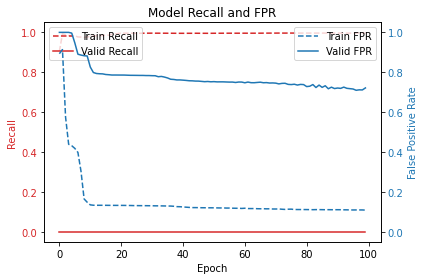

In [242]:
plot_model_recall_fpr(history)